In [1]:
pip install pandas numpy scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


# Player Clustering Based on Bustabit Game Data

This notebook aims to cluster players based on their behavior in the Bustabit game dataset. The pipeline includes data preprocessing, feature engineering, exploratory data analysis (EDA), feature scaling, dimensionality reduction using PCA, and KMeans clustering to group players into distinct behavioral categories. Additionally, it includes handling NaN values and infinite values, which are common in real-world datasets, using a robust imputation strategy to ensure clean and reliable data.


## 1. Data Preprocessing

We start by loading the dataset and converting the `PlayDate` column to a proper datetime format. 

- **NaN Checking**: We print out which columns contain NaN values to understand where data is missing.
- **NaN Handling**: We fill missing values in the 'CashedOut' column with 0, assuming NaN represents games where the player didn’t cash out.
- **Error Prevention**: This step ensures that missing values don’t disrupt the analysis pipeline later on.

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# 1. Data Preprocessing
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df['PlayDate'] = pd.to_datetime(df['PlayDate'])
    
    # Check for NaN values
    print("Columns with NaN values:")
    print(df.isnull().sum())
    
    # Handle NaN values in 'CashedOut' column
    df['CashedOut'] = df['CashedOut'].fillna(0)  # Assume 0 for non-cashed out games
    
    return df


## 2. Feature Engineering
In this step, we extract features that describe each player’s behavior in the game. We calculate:

- Aggregate statistics like mean, sum, and count for bets, cash-outs, profits, and bonuses.
- Risk tolerance: Calculated as the ratio of the standard deviation of cash-outs to their mean.
- Win rate: The total profit divided by the total bets placed.
### Improvements:
- Handling Infinite Values: We replace infinite values (which can occur in division) with NaN.
- Imputation: We use SimpleImputer to replace remaining NaN values with the mean for each feature.

In [4]:
# 2. Feature Engineering
def engineer_features(df):
    player_features = df.groupby('Username').agg({
        'Bet': ['mean', 'std', 'sum', 'count'],
        'CashedOut': ['mean', 'std'],
        'Profit': ['mean', 'sum'],
        'BustedAt': ['mean'],
        'Bonus': ['mean', 'sum']
    })
    player_features.columns = ['_'.join(col).strip() for col in player_features.columns.values]
    
    # Calculate risk tolerance (std of CashedOut / mean of CashedOut)
    player_features['risk_tolerance'] = player_features['CashedOut_std'] / player_features['CashedOut_mean']
    player_features['win_rate'] = player_features['Profit_sum'] / player_features['Bet_sum']
    
    # Handle potential NaN or inf values from division
    player_features = player_features.replace([np.inf, -np.inf], np.nan)
    
    # Impute NaN values
    imputer = SimpleImputer(strategy='mean')
    player_features_imputed = pd.DataFrame(imputer.fit_transform(player_features), 
                                           columns=player_features.columns, 
                                           index=player_features.index)
    
    return player_features_imputed


## 3. Exploratory Data Analysis (EDA)
Before moving forward, we explore the dataset by analyzing the correlation between the features. This helps us understand how different features relate to one another and whether any strong relationships exist that could influence the clustering.

In [5]:
# 3. EDA (simplified for brevity)
def perform_eda(player_features):
    correlation = player_features.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation, annot=True, cmap='coolwarm')
    plt.title('Feature Correlation Heatmap')
    plt.show()


## 4. Feature Scaling
We scale the features to ensure that all variables contribute equally to the clustering process. This prevents features with larger ranges from dominating the analysis. We use StandardScaler to standardize the data.


In [6]:
# 4. Feature Scaling
def scale_features(player_features):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(player_features)
    return scaled_features, scaler


## 5. Dimensionality Reduction with PCA
To reduce the dimensionality of the feature set and capture the most important information, we apply PCA (Principal Component Analysis). This reduces noise and simplifies the clustering process, improving accuracy and performance.



In [7]:
# 5. Dimensionality Reduction
def apply_pca(scaled_features, n_components=0.95):
    pca = PCA(n_components=n_components)
    pca_features = pca.fit_transform(scaled_features)
    return pca_features, pca


## 6. KMeans Clustering
We now cluster the data using the KMeans algorithm.

Elbow Method: We plot the inertia for different numbers of clusters and identify the optimal number of clusters by looking for the "elbow point."

In [8]:
# 6. Clustering
def apply_kmeans(pca_features, max_clusters=10):
    inertias = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pca_features)
        inertias.append(kmeans.inertia_)
    
    # Plot elbow curve
    plt.plot(range(1, max_clusters + 1), inertias, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.show()
    
    # Choose optimal k (adjust based on the elbow curve)
    optimal_k = 3  # Adjust as needed based on the elbow curve
    
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_features)
    return cluster_labels, kmeans


## 7. Cluster Analysis and Interpretation
We analyze each cluster to understand the characteristics of the players within it. This gives insights into player behavior, such as identifying risk-takers, conservative players, and balanced players.

In [9]:
# 7. Cluster Analysis and Interpretation
def analyze_clusters(player_features, cluster_labels):
    player_features['Cluster'] = cluster_labels
    cluster_means = player_features.groupby('Cluster').mean()
    print("Cluster Means:")
    print(cluster_means)
    
    # Visualize clusters (example using two features)
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=player_features, x='Bet_mean', y='CashedOut_mean', hue='Cluster', palette='deep')
    plt.title('Player Clusters: Bet Mean vs CashedOut Mean')
    plt.show()


## 8. Assign Player Types
Finally, we assign meaningful labels to each cluster, such as "Risk-takers", "Conservative players", and "Balanced players". These labels help us understand the behavior of different player types.



Columns with NaN values:
Id               0
GameID           0
Username         0
Bet              0
CashedOut    21266
Bonus        21266
Profit       21266
BustedAt         0
PlayDate         0
dtype: int64


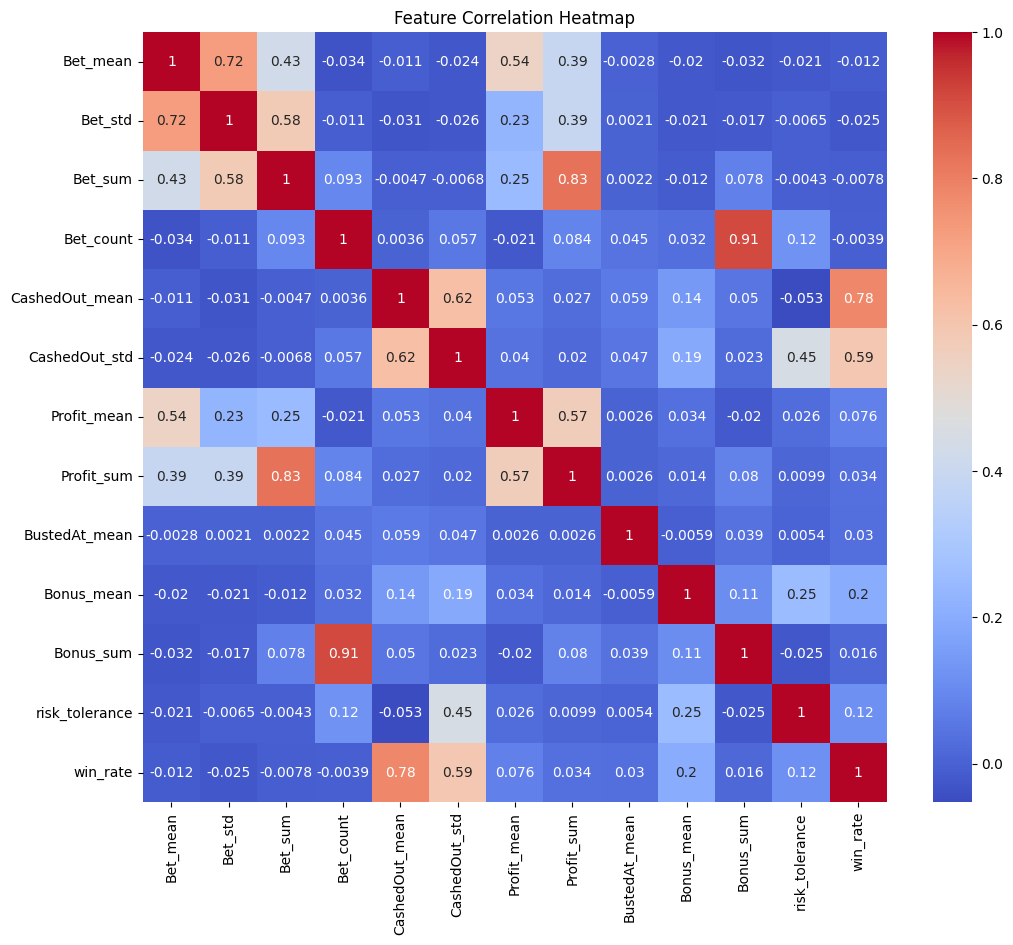

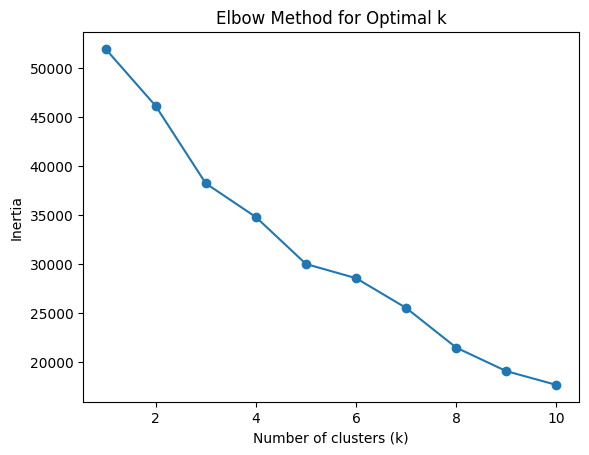

Cluster Means:
              Bet_mean       Bet_std       Bet_sum   Bet_count  \
Cluster                                                          
0           841.655624    2665.71361  7.337725e+04  104.147541   
1          3765.186251    4281.77004  1.804143e+04    7.759180   
2        298831.567555  250777.98436  3.652290e+06   17.647059   

         CashedOut_mean  CashedOut_std    Profit_mean    Profit_sum  \
Cluster                                                               
0              0.978177       1.071566     713.521217  2.554188e+04   
1              0.961286       0.995613    2166.651861  4.948979e+03   
2              1.040170       0.754705  206469.179644  1.169556e+06   

         BustedAt_mean  Bonus_mean  Bonus_sum  risk_tolerance  win_rate  
Cluster                                                                  
0            16.319814    1.661600  90.817213        1.113406  0.356404  
1             9.815889    1.518407   5.782312        1.057708  0.378032  
2 

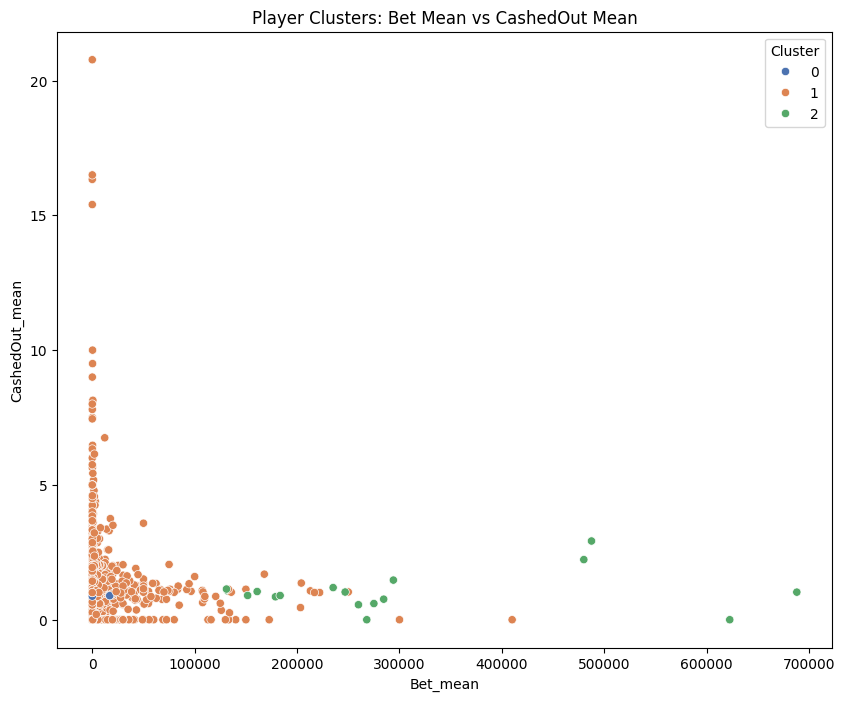

PlayerType          
Conservative players    3949
Risk-takers              183
Balanced players          17
Name: count, dtype: int64


In [11]:
# Main execution
if __name__ == "__main__":
    file_path = "bustabit.csv"  # Use the correct file path
    
    # Execute the pipeline
    df = load_and_preprocess_data(file_path)
    player_features = engineer_features(df)
    perform_eda(player_features)
    scaled_features, _ = scale_features(player_features)
    pca_features, _ = apply_pca(scaled_features)
    cluster_labels, _ = apply_kmeans(pca_features)
    analyze_clusters(player_features, cluster_labels)

    # Interpret results and assign cluster labels
    cluster_interpretations = {
        0: "Risk-takers",
        1: "Conservative players",
        2: "Balanced players"
    }
    
    player_features['PlayerType'] = player_features['Cluster'].map(cluster_interpretations)
    print(player_features[['PlayerType']].value_counts())

    # Save results
    player_features.to_csv("player_clusters.csv")


## Conclusion
